In [4]:
import sys
sys.path.append('eucalc_directory')
import eucalc as ec
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from numpy import genfromtxt
from sklearn.decomposition import PCA

# Path to the folder containing the CSV files
datafolder = "Old_Young_Comparison"

all_files = os.listdir(datafolder)

# Get all CSV filenames in the folder
names = [file for file in all_files if file.lower().endswith(('.tif', '.tiff'))]


# Split names into K8 and K14 groups
names_k8 = [nm for nm in names if 'K8' in nm]
names_k14 = [nm for nm in names if 'K14' in nm]

## set up functions

In [3]:
import os
import tifffile as tiff
import eucalc as ec
import matplotlib.colors as mcolors
from PIL import Image
class EctImg:
    def __init__(self, nm, img, k=20, xinterval=(-1., 1.), xpoints=100):
        self.xinterval = xinterval
        self.xpoints = xpoints
        self.image = self.compute(img, k, xinterval, xpoints)
        self.nm = nm
    def compute(self, img, k, xinterval, xpoints):
        cplx = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.random.uniform(0, 2 * np.pi, k + 1)
        ect1 = np.empty((k, xpoints), dtype=float)
        for i in range(k):
            theta = thetas[i]
            direction = np.array((np.sin(theta), np.cos(theta)))
            ect_dir = cplx.compute_euler_characteristic_transform(direction)
            T = np.linspace(xinterval[0], xinterval[1], xpoints)
            ect1[i] = [ect_dir.evaluate(t) for t in T]
        return ect1


def compute_ExIm(names, datafolder, k=480, xinterval=(-1.5, 1.5), xpoints=300):
    ExImage = []
    
    for nm in names: 
        file_path = os.path.join(datafolder, nm)
        with Image.open(file_path) as img:
            img_array = np.array(img)
        
        # Now, compute the ECT image using the new array
        ect = EctImg(nm, img_array, k, xinterval, xpoints)
        exim = ect.compute(img_array, k, xinterval, xpoints)
        ExImage.append(exim)

    return ExImage

In [24]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

def wasserstein_distance(empirical1, empirical2, p=2, delta_x=1.0):
    cost_matrix = cdist(empirical1, empirical2, metric='minkowski', p=p) * (delta_x ** (1.0 / p))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    avg_cost_p = np.mean(cost_matrix[row_ind, col_ind] ** p)
    return avg_cost_p ** (1.0 / p)

def compute_wasserstein_distances(measures, p=2, delta_x=1.0):
    distances = []
    n = len(measures)
    for i in range(n):
        for j in range(i + 1, n):
            dist = wasserstein_distance(measures[i], measures[j], p=p, delta_x=delta_x)
            distances.append(dist)
    return distances


## Monte Carlo testing

In [ ]:
import numpy as np
import ot
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment


# -----------------------------------------------------------------------------
# 1) Your existing Wasserstein distance on curve-space measures
def wasserstein_distance(emp1, emp2, p=1, delta_x=1.0):
    C = cdist(emp1, emp2, metric='minkowski', p=p) * (delta_x ** (1.0 / p))
    i1, i2 = linear_sum_assignment(C)
    avg_cost_p = np.mean(C[i1, i2] ** p)
    return avg_cost_p ** (1.0 / p)


# -----------------------------------------------------------------------------
# 2) Load measures via your compute_ExIm (must be already in scope)
measures_old   = compute_ExIm(names_k14, datafolder, k=480, xinterval=(-1.5,1.5), xpoints=300)
measures_young = compute_ExIm(names_k8,  datafolder, k=480, xinterval=(-1.5,1.5), xpoints=300)
delta_x = 3.0 / 300.0  # delta_x for the Wasserstein distance
m0    = measures_old[0]       # one “old” quadrant
young = measures_young        # the n “young” quadrants
all_meas = [m0] + young       # list of n+1 measures


# -----------------------------------------------------------------------------
# 3) Build “within-measure” atom-weights (uniform per measure)
measures_weights = [
    np.ones(m.shape[0]) / m.shape[0]
    for m in all_meas
]

# 4) Build “measure-level” weights (uniform across measures)
N = len(all_meas)
weights_measure = np.ones(N) / N


# -----------------------------------------------------------------------------
# 5) Initialize barycenter support X_init and its atom-weights b_init
k = all_meas[0].shape[0]  # number of atoms per measure
d = all_meas[0].shape[1]  # dimension of each atom

# e.g. sample k points from the union of all supports as a starting guess
D = np.zeros((N, N))
for i in range(N):
    for j in range(i+1, N):
        D[i, j] = D[j, i] = wasserstein_distance(all_meas[i], all_meas[j], p=2, delta_x=delta_x)
medoid_idx = np.argmin(D.sum(axis=1))
X_init = all_meas[medoid_idx].copy()
                  # (k, d)
b_init = np.ones(k) / k               # uniform weights for the barycenter atoms


# -----------------------------------------------------------------------------
# 6) Call the LP-based free-support barycenter solver (correct API)
mu = ot.lp.free_support_barycenter(
    all_meas,            # list of N point-clouds, each shape (k, d)
    measures_weights,    # list of N vectors length-k summing to 1
    X_init,              # initial barycenter locations (k, d)
    b_init,              # barycenter’s atom-weights (length k, sums to 1)
    weights=weights_measure,  # length-N, sums to 1: influence of each measure
    numItermax=5000,      # optional: outer iterations
    stopThr=1e-6,        # optional: convergence tolerance
    verbose=True
)
# mu is an array of shape (k, d) giving your true 2-Wasserstein barycenter


# -----------------------------------------------------------------------------
# 7) Compute S₀ and Sᵢ relative to μ
S0  = wasserstein_distance(m0, mu,  p=2, delta_x=1.0)
Sis = [wasserstein_distance(m,  mu,  p=2, delta_x=1.0) for m in young]

# 8) Empirical P-value: P(S0 ≥ Si)
p_val = np.mean([S0 >= s for s in Sis])

print(f"S₀ = {S0:.4f}")
print(f"Sᵢ = {[f'{s:.4f}' for s in Sis]}")
print(f"Empirical P = {p_val:.3f}")


iteration %d, displacement_square_norm=%f
 0 282595.6048403095
iteration %d, displacement_square_norm=%f
 1 8576.84308668915
iteration %d, displacement_square_norm=%f
 2 2462.476096012697
iteration %d, displacement_square_norm=%f
 3 1033.8778020234083
iteration %d, displacement_square_norm=%f
 4 498.9041856774452
iteration %d, displacement_square_norm=%f
 5 287.26482840706217
iteration %d, displacement_square_norm=%f
 6 165.2537195000992
iteration %d, displacement_square_norm=%f
 7 101.78020234080542
iteration %d, displacement_square_norm=%f
 8 65.451299345368
iteration %d, displacement_square_norm=%f
 9 45.33346558222574
iteration %d, displacement_square_norm=%f
 10 28.255108113469557
iteration %d, displacement_square_norm=%f
 11 16.111485816306296
iteration %d, displacement_square_norm=%f
 12 13.12041261654434
iteration %d, displacement_square_norm=%f
 13 11.146201150565364
iteration %d, displacement_square_norm=%f
 14 7.263638167030353
iteration %d, displacement_square_norm=%f
 15 8

In [25]:
def monte_carlo_test(test_measure, sampled_measures, p=2, delta_x=1.0):
    all_measures = [test_measure] + sampled_measures
    N = len(all_measures)
    measures_weights = [np.ones(m.shape[0]) / m.shape[0] for m in all_measures]
    weights_measure = np.ones(N) / N
    k = all_measures[0].shape[0]
    d = all_measures[0].shape[1]
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1, N):
            D[i, j] = D[j, i] = wasserstein_distance(all_measures[i], all_measures[j], p=p, delta_x=delta_x)
    medoid_idx = np.argmin(D.sum(axis=1))
    X_init = all_measures[medoid_idx].copy()
    b_init = np.ones(k) / k
    mu = ot.lp.free_support_barycenter(
        all_measures,
        measures_weights,
        X_init,
        b_init,
        weights=weights_measure,
        numItermax=5000,
        stopThr=1e-6,
        verbose=False
    )
    
    S0 = wasserstein_distance(test_measure, mu, p=p, delta_x=delta_x)
    Sis = [wasserstein_distance(m, mu, p=p, delta_x=delta_x) for m in sampled_measures]
    p_val = np.mean([S0 >= s for s in Sis])
    return S0, Sis, p_val

### K8

#### Old in young distribution

In [ ]:
import ot
names_k8_old = [nm for nm in names_k8 if nm[0]== 'O']
names_k8_young = [nm for nm in names_k8 if nm[0]== 'Y']
measures_old   = compute_ExIm(names_k8_old, datafolder, k=480, xinterval=(-1.5,1.5), xpoints=9000)
measures_young = compute_ExIm(names_k8_young,  datafolder, k=480, xinterval=(-1.5,1.5), xpoints=9000)
delta_x = 3.0 / 9000.0  # delta_x for the Wasserstein distance
p_values = []
for i in range(len(measures_old)):
    _, _, p_val = monte_carlo_test(measures_old[i], measures_young, p=2, delta_x=delta_x)
    p_values.append((p_val,i))
p_values.sort(key=lambda x: x[0])  # Sort by p-value
print('Minimal p-value:', p_values[0][0])
print('Name of the measure with minimal p-value:', names_k8_old[p_values[0][1]])
    

Minimal p-value: 0.1
Name of the measure with minimal p-value: O2_K8._4.tif


#### Young in old distribution

In [26]:
measures_old   = compute_ExIm(names_k8_old, datafolder, k=480, xinterval=(-1.5,1.5), xpoints=9000)
measures_young = compute_ExIm(names_k8_young,  datafolder, k=480, xinterval=(-1.5,1.5), xpoints=9000)
delta_x = 3.0 / 9000.0  # delta_x for the Wasserstein distance
young_p_values = []
for i in range(len(measures_young)):
    _, _, p_val = monte_carlo_test(measures_young[i], measures_old, p=2, delta_x=delta_x)
    young_p_values.append((p_val, i))
young_p_values.sort(key=lambda x: x[0])  # Sort by p-value
print('Minimal p-value for young measures:', young_p_values[0][0])
print('Name of the measure with minimal p-value for young measures:', names_k8_young[young_p_values[0][1]])

Minimal p-value for young measures: 0.06
Name of the measure with minimal p-value for young measures: Y1_K8._9.tif


#### Plot the two most distinct quadrants

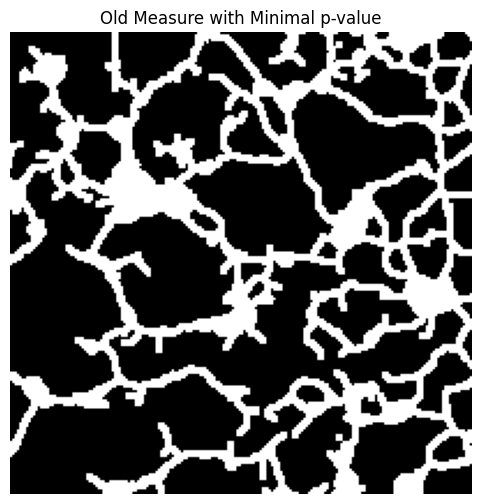

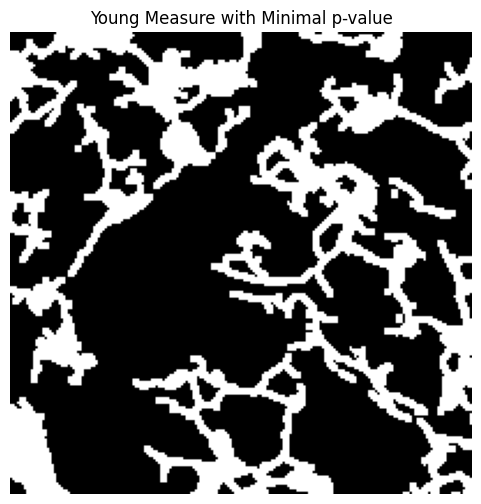

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_tiff(filename, title):
    directory = "Old_Young_Comparison"
    path = os.path.join(directory, filename)

    # Pillow handles CCITT-RLE and most TIFF variants
    with Image.open(path) as img:
        arr = np.array(img)

    # Plot
    plt.figure(figsize=(6, 6))
    if arr.ndim == 2:
        plt.imshow(arr, cmap='gray')
    else:
        plt.imshow(arr)
    plt.axis('off')
    plt.title(title)
    plt.show()

# Example calls:
plot_tiff(names_k8_old[p_values[0][1]], 'Old Measure with Minimal p-value')
plot_tiff(names_k8_young[young_p_values[0][1]], 'Young Measure with Minimal p-value')


#### EulerImage for most distinct quadrants

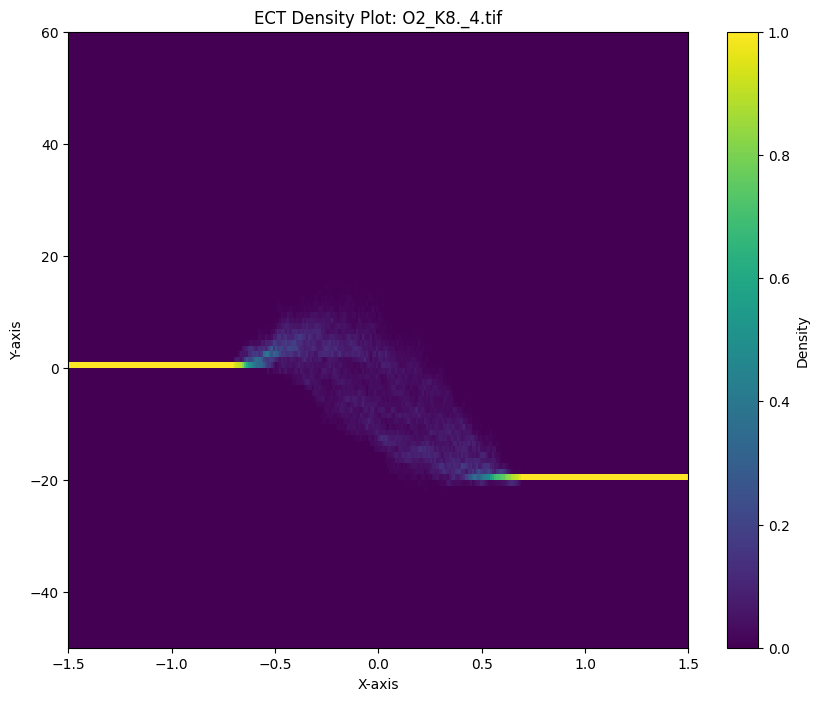

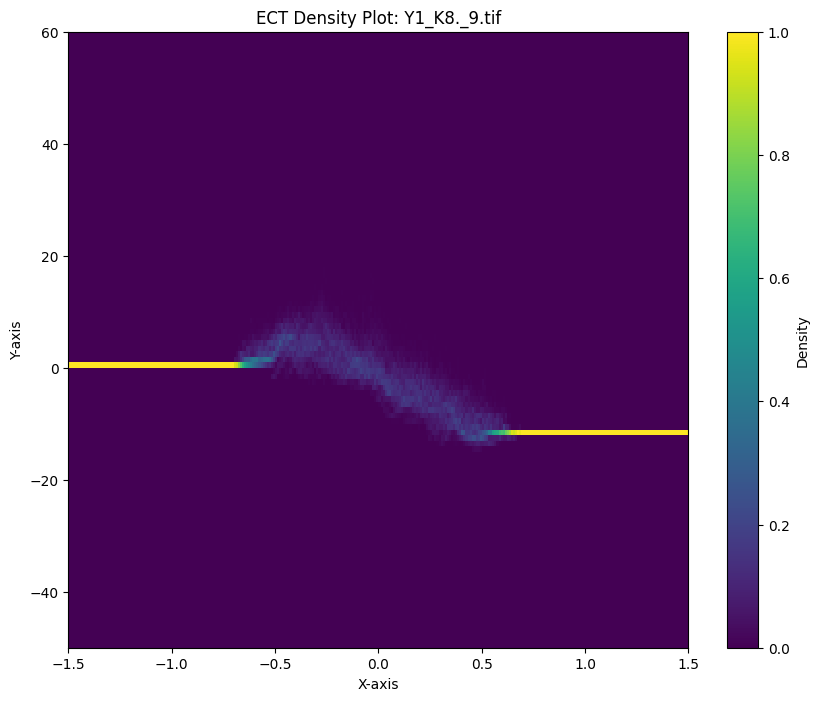

In [28]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import label
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed

import eucalc as ec  # adjust import path if needed

class EulerImage:
    """
    Encapsulates an image and its Euler Characteristic Transform (ECT) embedding,
    and provides a 2D density-plot visualization.
    """
    def __init__(
        self,
        name: str,
        img: np.ndarray,
        k: int = 360,
        xinterval: tuple = (-1.5, 1.5),
        xpoints: int = 12000,
        yinterval: tuple = (-1.5, 1.5),
        ypoints: int = 100
    ):
        self.name = name
        self.xinterval = xinterval
        self.yinterval = yinterval
        self.xpoints = xpoints
        self.ypoints = ypoints

        # 1) compute raw ECT embedding
        self.embedding = self._compute_ect(img, k, xinterval, xpoints)

        # 2) convert embedding into a density image
        self.image = self._embedding_to_density(
            self.embedding, xinterval, xpoints, yinterval, ypoints
        )

    def _compute_ect(
        self,
        img: np.ndarray,
        k: int,
        xinterval: tuple,
        xpoints: int
    ) -> np.ndarray:
        """
        Compute the Euler Characteristic Transform for the given binary image.
        Returns an array of shape (k, xpoints).
        """
        cplx = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.linspace(0, 2 * np.pi, k, endpoint=False)
        ect_vals = np.empty((k, xpoints), dtype=float)
        T = np.linspace(xinterval[0], xinterval[1], xpoints)
        for i, theta in enumerate(thetas):
            direction = np.array((np.sin(theta), np.cos(theta)))
            ect_dir = cplx.compute_euler_characteristic_transform(direction)
            ect_vals[i] = [ect_dir.evaluate(t) for t in T]
        return ect_vals

    def _embedding_to_density(
        self,
        embedding: np.ndarray,
        xinterval: tuple,
        xpoints: int,
        yinterval: tuple,
        ypoints: int
    ) -> np.ndarray:
        """
        Convert the raw ECT embedding into a 2D density image.
        """
        # bin edges for the ECT values along the Y-axis
        y_edges = np.linspace(yinterval[0], yinterval[1], ypoints + 1)
        density = np.zeros((ypoints, xpoints), dtype=float)
        for xi in range(xpoints):
            col = embedding[:, xi]
            counts, _ = np.histogram(col, bins=y_edges)
            density[:, xi] = counts / embedding.shape[0]
        return density

    def plot(self) -> None:
        """
        Plot the ECT density image using matplotlib.
        """
        fig, ax = plt.subplots(figsize=(10, 8))
        extent = [
            self.xinterval[0], self.xinterval[1],
            self.yinterval[0], self.yinterval[1]
        ]
        img = ax.imshow(
            self.image,
            aspect='auto',
            extent=extent,
            origin='lower',
            interpolation='none'
        )
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Density')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title(f'ECT Density Plot: {self.name}')
        plt.show()


# 1) pick the two indices with smallest p-values
best_old_idx   = p_values[0][1]
best_young_idx = young_p_values[0][1]

# 2) get their filenames
best_old_name   = names_k8_old[best_old_idx]
best_young_name = names_k8_young[best_young_idx]

# 3) helper to load a GIF as a grayscale numpy array
def load_gray(path: str) -> np.ndarray:
    img = Image.open(path)
    if img.mode == 'RGB':
        img = img.convert('L')
    return np.array(img)

# 4) load the two images
img_old   = load_gray(os.path.join(datafolder, best_old_name))
img_young = load_gray(os.path.join(datafolder, best_young_name))

# 5) instantiate and plot
ect_old = EulerImage(
    name=best_old_name,
    img=img_old,
    k=480,
    xinterval=(-1.5, 1.5),
    xpoints=300,
    yinterval=(-50, 60),
    ypoints=110
)
ect_young = EulerImage(
    name=best_young_name,
    img=img_young,
    k=480,
    xinterval=(-1.5, 1.5),
    xpoints=300,
    yinterval=(-50, 60),
    ypoints=110
)

ect_old.plot()
ect_young.plot()



#### Quadrants most similar to other group

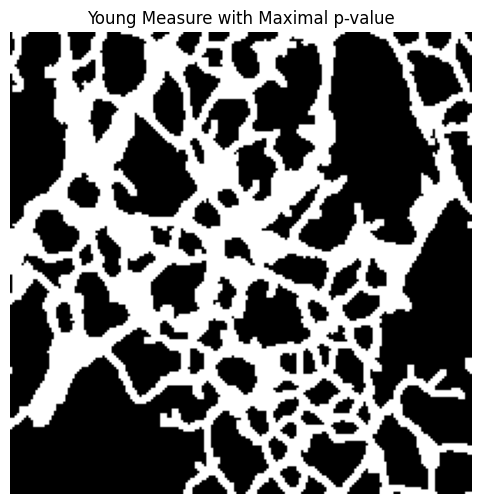

p-value for this measure: 1.0


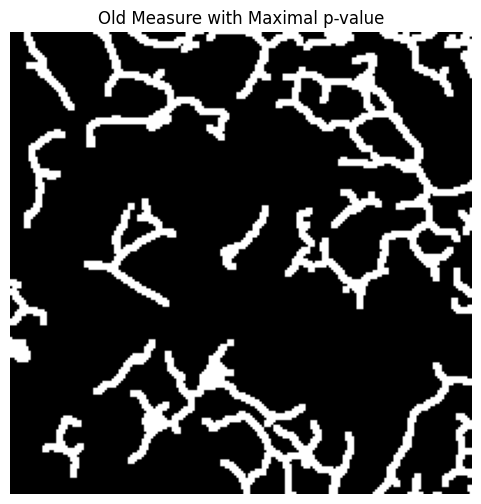

p-value for this measure: 0.9


In [37]:
plot_tiff(names_k8_young[young_p_values[-1][1]], 'Young Measure with Maximal p-value')
print(f'p-value for this measure: {young_p_values[-1][0]}')
plot_tiff(names_k8_old[p_values[-1][1]], 'Old Measure with Maximal p-value')
print(f'p-value for this measure: {p_values[-1][0]}')

### K14

#### Old in young distribution

In [30]:
names_k14_old = [nm for nm in names_k14 if nm[0]== 'O']
names_k14_young = [nm for nm in names_k14 if nm[0]== 'Y']
measures_old   = compute_ExIm(names_k14_old, datafolder, k=480, xinterval=(-1.5,1.5), xpoints=9000)
measures_young = compute_ExIm(names_k14_young,  datafolder, k=480, xinterval=(-1.5,1.5), xpoints=9000)
delta_x = 3.0 / 9000.0  # delta_x for the Wasserstein distance
p_values_14 = []
for i in range(len(measures_old)):
    _, _, p_val = monte_carlo_test(measures_old[i], measures_young, p=2, delta_x=delta_x)
    p_values_14.append((p_val,i))
p_values_14.sort(key=lambda x: x[0])  # Sort by p-value
print('Minimal p-value:', p_values_14[0][0])
print('Name of the measure with minimal p-value:', names_k14_old[p_values_14[0][1]])
    

Minimal p-value: 0.2
Name of the measure with minimal p-value: O3_K14._9.tif


#### Young in old distribution

In [31]:
measures_old   = compute_ExIm(names_k14_old, datafolder, k=480, xinterval=(-1.5,1.5), xpoints=9000)
measures_young = compute_ExIm(names_k14_young,  datafolder, k=480, xinterval=(-1.5,1.5), xpoints=9000)
delta_x = 3.0 / 9000.0  # delta_x for the Wasserstein distance
young_p_values_14 = []
for i in range(len(measures_young)):
    _, _, p_val = monte_carlo_test(measures_young[i], measures_old, p=2, delta_x=delta_x)
    young_p_values_14.append((p_val, i))
young_p_values_14.sort(key=lambda x: x[0])  # Sort by p-value
print('Minimal p-value for young measures:', young_p_values_14[0][0])
print('Name of the measure with minimal p-value for young measures:', names_k14_young[young_p_values_14[0][1]])

Minimal p-value for young measures: 0.0
Name of the measure with minimal p-value for young measures: Y1_K14._8.tif


#### Plot the two most distinct quadrants

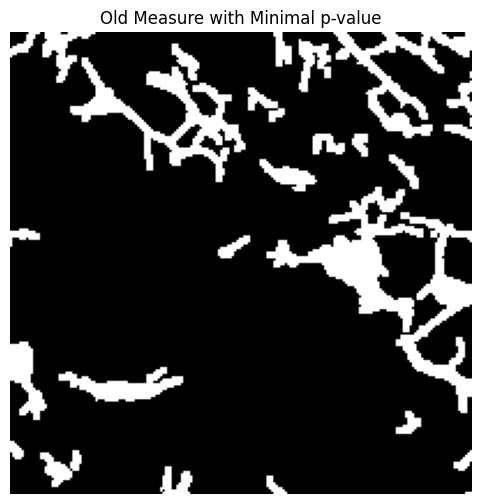

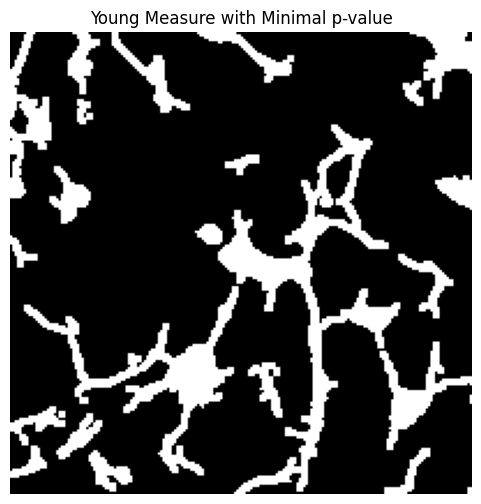

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_tiff(filename, title):
    directory = "Old_Young_Comparison"
    path = os.path.join(directory, filename)

    # Pillow handles CCITT-RLE and most TIFF variants
    with Image.open(path) as img:
        arr = np.array(img)

    # Plot
    plt.figure(figsize=(6, 6))
    if arr.ndim == 2:
        plt.imshow(arr, cmap='gray')
    else:
        plt.imshow(arr)
    plt.axis('off')
    plt.title(title)
    plt.show()

# Example calls:
plot_tiff(names_k14_old[p_values_14[0][1]], 'Old Measure with Minimal p-value')
plot_tiff(names_k14_young[young_p_values_14[0][1]], 'Young Measure with Minimal p-value')


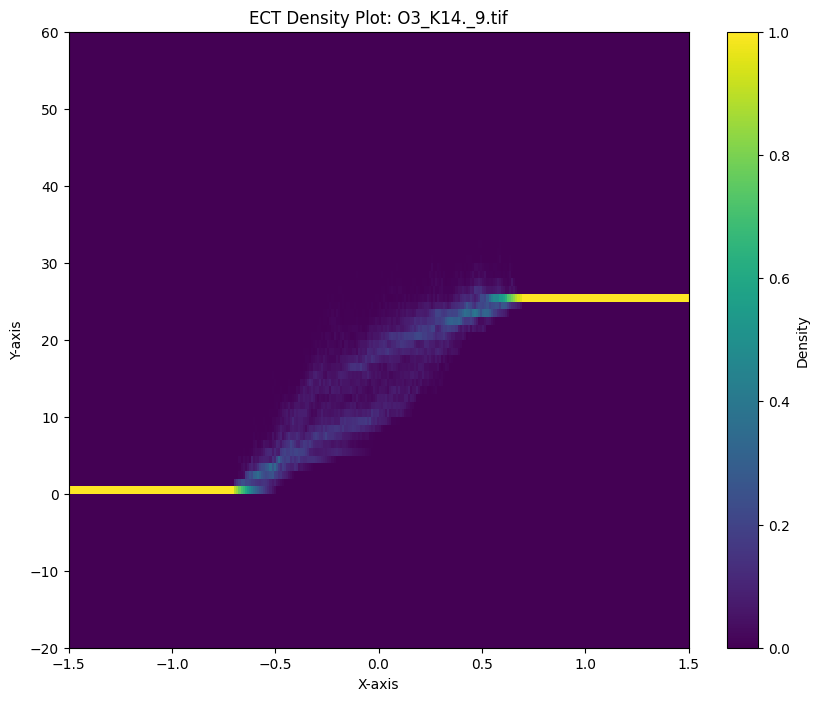

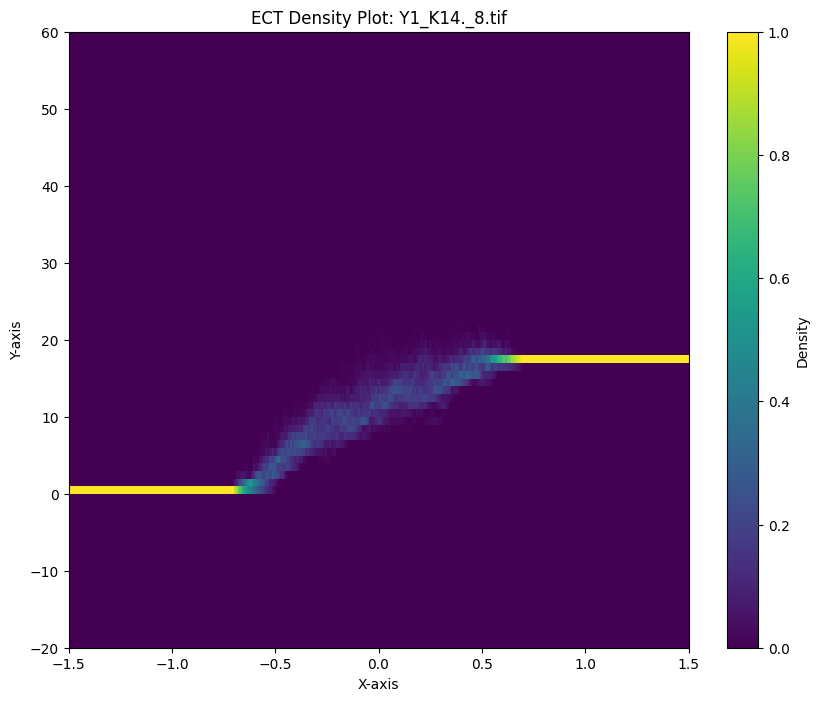

In [33]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import label
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed

import eucalc as ec  # adjust import path if needed

class EulerImage:
    """
    Encapsulates an image and its Euler Characteristic Transform (ECT) embedding,
    and provides a 2D density-plot visualization.
    """
    def __init__(
        self,
        name: str,
        img: np.ndarray,
        k: int = 360,
        xinterval: tuple = (-1.5, 1.5),
        xpoints: int = 12000,
        yinterval: tuple = (-1.5, 1.5),
        ypoints: int = 100
    ):
        self.name = name
        self.xinterval = xinterval
        self.yinterval = yinterval
        self.xpoints = xpoints
        self.ypoints = ypoints

        # 1) compute raw ECT embedding
        self.embedding = self._compute_ect(img, k, xinterval, xpoints)

        # 2) convert embedding into a density image
        self.image = self._embedding_to_density(
            self.embedding, xinterval, xpoints, yinterval, ypoints
        )

    def _compute_ect(
        self,
        img: np.ndarray,
        k: int,
        xinterval: tuple,
        xpoints: int
    ) -> np.ndarray:
        """
        Compute the Euler Characteristic Transform for the given binary image.
        Returns an array of shape (k, xpoints).
        """
        cplx = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.linspace(0, 2 * np.pi, k, endpoint=False)
        ect_vals = np.empty((k, xpoints), dtype=float)
        T = np.linspace(xinterval[0], xinterval[1], xpoints)
        for i, theta in enumerate(thetas):
            direction = np.array((np.sin(theta), np.cos(theta)))
            ect_dir = cplx.compute_euler_characteristic_transform(direction)
            ect_vals[i] = [ect_dir.evaluate(t) for t in T]
        return ect_vals

    def _embedding_to_density(
        self,
        embedding: np.ndarray,
        xinterval: tuple,
        xpoints: int,
        yinterval: tuple,
        ypoints: int
    ) -> np.ndarray:
        """
        Convert the raw ECT embedding into a 2D density image.
        """
        # bin edges for the ECT values along the Y-axis
        y_edges = np.linspace(yinterval[0], yinterval[1], ypoints + 1)
        density = np.zeros((ypoints, xpoints), dtype=float)
        for xi in range(xpoints):
            col = embedding[:, xi]
            counts, _ = np.histogram(col, bins=y_edges)
            density[:, xi] = counts / embedding.shape[0]
        return density

    def plot(self) -> None:
        """
        Plot the ECT density image using matplotlib.
        """
        fig, ax = plt.subplots(figsize=(10, 8))
        extent = [
            self.xinterval[0], self.xinterval[1],
            self.yinterval[0], self.yinterval[1]
        ]
        img = ax.imshow(
            self.image,
            aspect='auto',
            extent=extent,
            origin='lower',
            interpolation='none'
        )
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Density')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title(f'ECT Density Plot: {self.name}')
        plt.show()


# 1) pick the two indices with smallest p-values
best_old_idx   = p_values_14[0][1]
best_young_idx = young_p_values_14[0][1]

# 2) get their filenames
best_old_name   = names_k14_old[best_old_idx]
best_young_name = names_k14_young[best_young_idx]

# 3) helper to load a GIF as a grayscale numpy array
def load_gray(path: str) -> np.ndarray:
    img = Image.open(path)
    if img.mode == 'RGB':
        img = img.convert('L')
    return np.array(img)

# 4) load the two images
img_old   = load_gray(os.path.join(datafolder, best_old_name))
img_young = load_gray(os.path.join(datafolder, best_young_name))

# 5) instantiate and plot
ect_old = EulerImage(
    name=best_old_name,
    img=img_old,
    k=480,
    xinterval=(-1.5, 1.5),
    xpoints=300,
    yinterval=(-20, 60),
    ypoints=80
)
ect_young = EulerImage(
    name=best_young_name,
    img=img_young,
    k=480,
    xinterval=(-1.5, 1.5),
    xpoints=300,
    yinterval=(-20, 60),
    ypoints=80
)

ect_old.plot()
ect_young.plot()



#### Quadrants most similar to the other age group

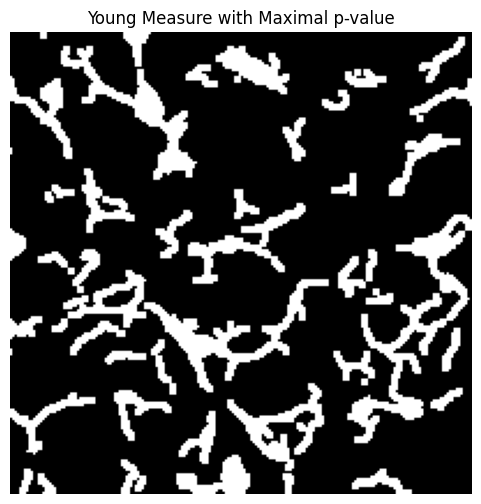

p-value for this measure: 0.96


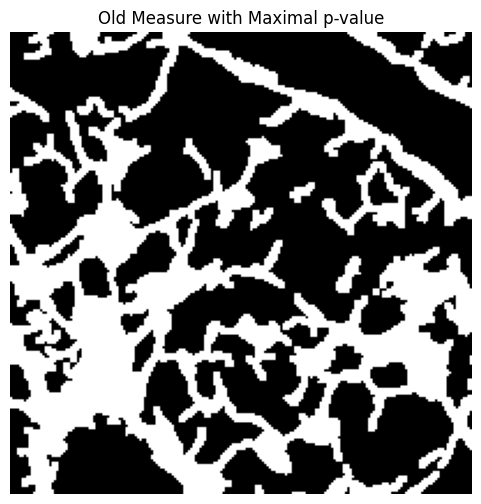

p-value for this measure: 1.0


In [42]:
plot_tiff(names_k14_young[young_p_values_14[-1][1]], 'Young Measure with Maximal p-value')
print(f'p-value for this measure: {young_p_values_14[-1][0]}')
plot_tiff(names_k14_old[p_values_14[-1][1]], 'Old Measure with Maximal p-value')
print(f'p-value for this measure: {p_values_14[-1][0]}')

## MDSCALE

### K8

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import MDS

# 1) Define the Wasserstein distance between two empirical distributions
def wasserstein_distance(empirical1, empirical2, p=2, delta_x=1.0):
    # Compute the cost matrix using the p-norm and scale by delta_x
    cost_matrix = cdist(empirical1, empirical2, metric='minkowski', p=p) * (delta_x ** (1.0 / p))
    # Solve the optimal transport problem via the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    # Compute the average p-cost over matched pairs
    avg_cost_p = np.mean(cost_matrix[row_ind, col_ind] ** p)
    # Return the p-th root
    return avg_cost_p ** (1.0 / p)

# 2) Compute the full pairwise Wasserstein distance matrix
def compute_wasserstein_distances_matrix(empirical_list, p=2, delta_x=1.0):
    n = len(empirical_list)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            d = wasserstein_distance(empirical_list[i], empirical_list[j], p=p, delta_x=delta_x)
            D[i, j] = D[j, i] = d
    return D

samp_eulers_k8 = compute_ExIm(names_k8, datafolder, k=480, xinterval=(-1.5, 1.5), xpoints=9000)
delta_x = 3.0 / 9000.0
# Build the distance matrix
distances_k8 = compute_wasserstein_distances_matrix(samp_eulers_k8, p=1, delta_x=delta_x)




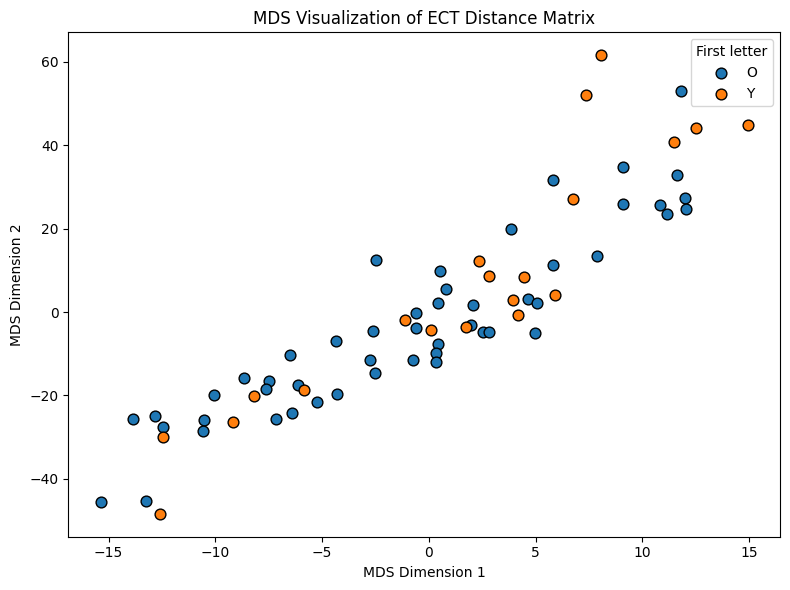

In [ ]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(distances_k8)

# 4) Prepare labels
labels = [os.path.basename(name)[0] for name in names_k8]
unique_labels = sorted(set(labels))

# Choose distinct colors for two classes, fallback to tab20 otherwise
if len(unique_labels) == 2:
    # Use a blue-orange palette for maximum contrast
    palette = ['tab:blue', 'tab:orange']
    label_to_color = {lbl: palette[i] for i, lbl in enumerate(unique_labels)}
else:
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))
    label_to_color = {lbl: cmap(i) for i, lbl in enumerate(unique_labels)}

# 5) Plot MDS embedding
plt.figure(figsize=(8, 6))
for lbl in unique_labels:
    idxs = [i for i, x in enumerate(labels) if x == lbl]
    plt.scatter(
        coords[idxs, 0],
        coords[idxs, 1],
        label=lbl,
        color=label_to_color[lbl],
        edgecolor='k',
        s=60
    )

plt.legend(title='First letter')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Visualization of ECT Distance Matrix')
plt.tight_layout()
plt.show()


### K14

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import MDS

# 1) Define the Wasserstein distance between two empirical distributions
def wasserstein_distance(empirical1, empirical2, p=2, delta_x=1.0):
    # Compute the cost matrix using the p-norm and scale by delta_x
    cost_matrix = cdist(empirical1, empirical2, metric='minkowski', p=p) * (delta_x ** (1.0 / p))
    # Solve the optimal transport problem via the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    # Compute the average p-cost over matched pairs
    avg_cost_p = np.mean(cost_matrix[row_ind, col_ind] ** p)
    # Return the p-th root
    return avg_cost_p ** (1.0 / p)

# 2) Compute the full pairwise Wasserstein distance matrix
def compute_wasserstein_distances_matrix(empirical_list, p=2, delta_x=1.0):
    n = len(empirical_list)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            d = wasserstein_distance(empirical_list[i], empirical_list[j], p=p, delta_x=delta_x)
            D[i, j] = D[j, i] = d
    return D

samp_eulers_k14 = compute_ExIm(names_k14, datafolder, k=480, xinterval=(-1.5, 1.5), xpoints=9000)
delta_x = 3.0 / 9000.0
# Build the distance matrix
distances_k14 = compute_wasserstein_distances_matrix(samp_eulers_k14, p=1, delta_x=delta_x)




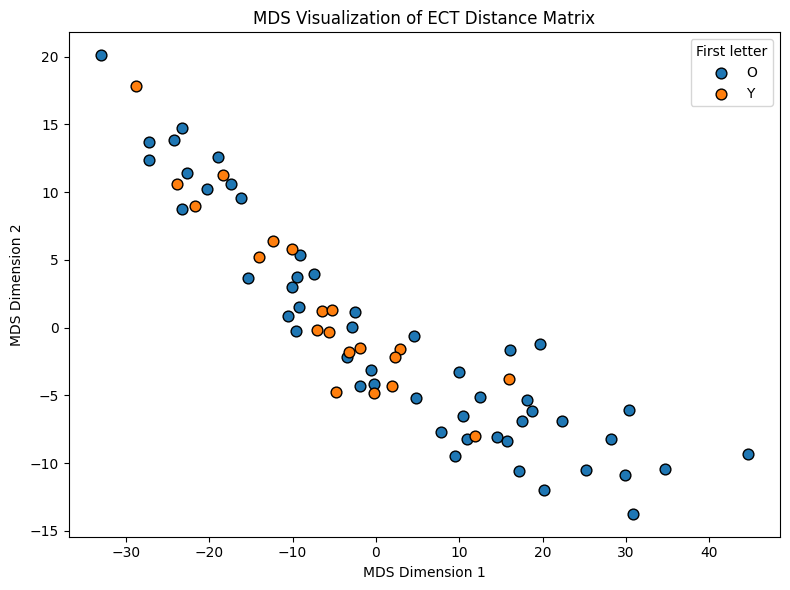

In [47]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(distances_k14)

# 4) Prepare labels
labels = [os.path.basename(name)[0] for name in names_k14]
unique_labels = sorted(set(labels))

# Choose distinct colors for two classes, fallback to tab20 otherwise
if len(unique_labels) == 2:
    # Use a blue-orange palette for maximum contrast
    palette = ['tab:blue', 'tab:orange']
    label_to_color = {lbl: palette[i] for i, lbl in enumerate(unique_labels)}
else:
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))
    label_to_color = {lbl: cmap(i) for i, lbl in enumerate(unique_labels)}

# 5) Plot MDS embedding
plt.figure(figsize=(8, 6))
for lbl in unique_labels:
    idxs = [i for i, x in enumerate(labels) if x == lbl]
    plt.scatter(
        coords[idxs, 0],
        coords[idxs, 1],
        label=lbl,
        color=label_to_color[lbl],
        edgecolor='k',
        s=60
    )

plt.legend(title='First letter')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Visualization of ECT Distance Matrix')
plt.tight_layout()
plt.show()
